<div class='bar_title'></div>

*Smart Cities and Geospatial Data Analysis*


# Part I - Common

1. Select two variables from the dataset
2. Explore the spatial distribution of those variables using choropleths. Comment on the details of your maps and interpret the results
3. Explore the degree of spatial autocorrelation (both global and local) of those variables. Describe the concepts behind your approach and interpret your results

[San Diego Tracts](https://geographicdata.science/book/data/sandiego/sandiego_tracts_cleaning.html): This dataset contains an extract of a set of variables from the 2017 ACS Census Tracts for the San Diego (CA) metropolitan area.

**San Diego** is a city in the U.S. state of California located alongside the Pacific Ocean in Southern California. With a population of over 1.3 million residents, the city is the eighth-most populous in the United States and the second-most populous in California after Los Angeles.

In [ ]:
import os
import esda
import pandas as pd
import geopandas as gpd
import seaborn as sns
import contextily as cx
import matplotlib.pyplot as plt
from sklearn import cluster

from pysal.lib import weights
from pysal.lib import examples
from splot.esda import moran_scatterplot, lisa_cluster
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

import importlib

/home/vscode/.local/lib/python3.8/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [ ]:
filepath = os.path.join('data', 'sandiego_tracts.gpkg')
gdf = gpd.read_file(filepath, sep =',')
gdf.info()
gdf_copy = gdf

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 628 entries, 0 to 627
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   GEOID                628 non-null    object  
 1   median_age           628 non-null    float64 
 2   total_pop            628 non-null    float64 
 3   total_pop_white      628 non-null    float64 
 4   tt_work              628 non-null    float64 
 5   hh_total             628 non-null    float64 
 6   hh_female            628 non-null    float64 
 7   total_bachelor       628 non-null    float64 
 8   median_hh_income     628 non-null    float64 
 9   income_gini          628 non-null    float64 
 10  total_housing_units  628 non-null    float64 
 11  total_rented         628 non-null    float64 
 12  median_no_rooms      628 non-null    float64 
 13  median_house_value   628 non-null    float64 
 14  NAME                 628 non-null    object  
 15  state          

To explore the spatial distribution of variables and analyze spatial autocorrelation, we might want to choose variables that are relevant to the characteristics of the neighborhoods and have potential spatial patterns. Here are two variables that we can consider:

**Median Household Income** (median_hh_income):
Median household income is a key socio-economic indicator that often exhibits spatial patterns. It represents the income earned by a household and can provide insights into the economic well-being of different areas.

**Percentage of Population with a Bachelor's Degree** (pct_bachelor):

The educational attainment of the population is an important factor in understanding the characteristics of different neighborhoods. Examining the percentage of the population with a bachelor's degree can highlight areas with higher educational levels.

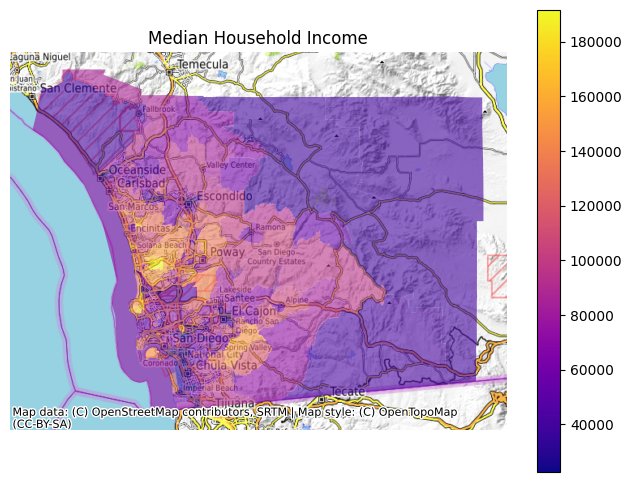

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
gdf.plot(column='median_hh_income', cmap='plasma', legend=True, ax=ax, alpha=0.6)
cx.add_basemap(ax=ax, crs=gdf.crs, source=cx.providers.OpenTopoMap)
ax.set_axis_off()
plt.title('Median Household Income')
plt.show()

**Interpetation**

San Diego is located immediately adjacent to the Mexico–United States border and is the seat of San Diego County, which has a population of nearly 3.3 million people as of 2021. San Diego is known for its mild year-round Mediterranean climate, extensive beaches and parks, its long association with the United States Navy, and its recent emergence as a healthcare and biotechnology development center.

We analysed the Median Household Income and mapped to show its distribution across the territory. As you can see on the map, the central districts (such as Solana Beach, San Marcos, Encinitas, Carmel Valley, Sorrento Valley, Coronado etc.) of the city have higher incomes (yellow) than the peripheral districts, with some exceptions (Spring Valley has high MHI). It should be noted that the city itself (especially the centre) has a low income level, but the suburbs have many wealthy areas (especially near the coast).

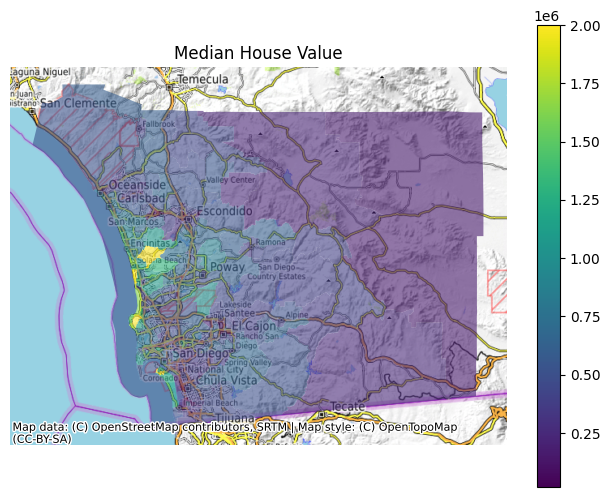

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
gdf.plot(column='median_house_value', cmap='viridis', legend=True, ax=ax, alpha=0.6)
cx.add_basemap(ax=ax, crs=gdf.crs, source=cx.providers.OpenTopoMap)
ax.set_axis_off()
plt.title("Median House Value")
plt.show()

**Interpretation**

The second indicator we considered was the Median House Value. The map clearly shows several areas where the cost of houses reaches approximately 2 million (Solana Beach, Coronado, La Jolla, Del Mar, Rancho Santa Fe). While other districts, especially those more remote from the city, have much lower values (approximately 250 - 500 thousand).

To explore the degree of spatial autocorrelation for the variables Median Household Income (median_hh_income) and Percentage of Population with a Bachelor's Degree (pct_bachelor), we can use Moran's I for global spatial autocorrelation and Local Indicators of Spatial Association (LISA) for local spatial autocorrelation.

### Median Household Income

Moran's I: 0.6057637090440126
Moran's I (p_value): 0.001


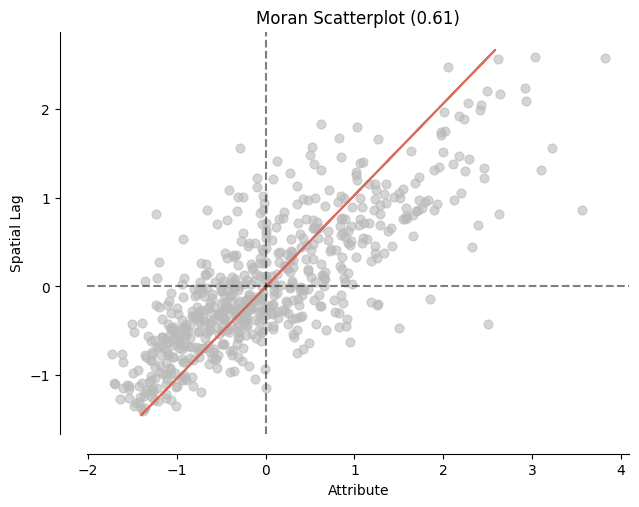

In [ ]:
w_queen = weights.Queen.from_dataframe(gdf, ids="GEOID")
w_queen.transform = 'R'
w_queen_score = weights.lag_spatial(w_queen, gdf["median_hh_income"])
gdf['w_area'] = w_queen_score

mi = esda.Moran(gdf['median_hh_income'], w_queen)
mi.I
mi.p_sim
moran_scatterplot(mi);

print(f"Moran's I: {mi.I}")
print(f"Moran's I (p_value): {mi.p_sim}")

The rising line in a scatter plot typically indicates a positive correlation between the two variables.

Moran's I close to -1 suggests negative spatial autocorrelation, indicating that dissimilar values tend to be near each other in space.
Moran's I close to 0 suggests no spatial autocorrelation, indicating a random spatial pattern.
Value is 0.6057, which is closer to 1, suggesting a positive spatial autocorrelation.

So there is a positive and relatively strong spatial autocorrelation. That indicates that high (low) values of Median Household Income are surrounded by high (low) values of Median Household Income, and viceversa. The metric is "consistent" over space. The p-value associated with Moran's I is used to test whether the observed spatial autocorrelation is statistically significant. In this case, the p-value is 0.001, which is typically considered very low. This suggests that the positive spatial autocorrelation you observed is likely not due to random chance.

/home/vscode/.local/lib/python3.8/site-packages/esda/moran.py:1059: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim


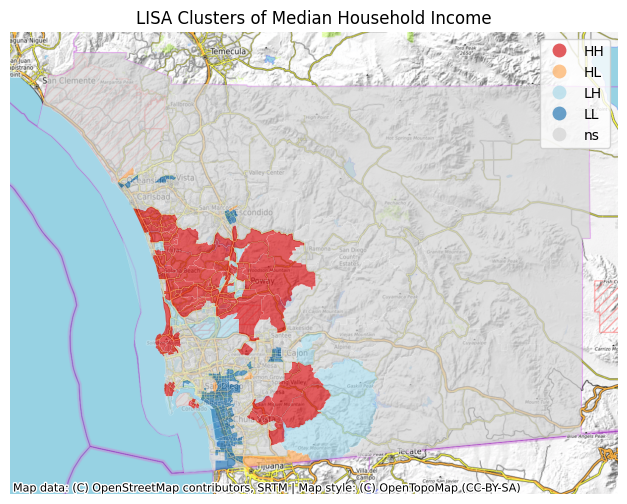

In [ ]:
lisa = esda.Moran_Local(gdf['median_hh_income'], w_queen)

# Break observations into significant or not
gdf['significant'] = lisa.p_sim < 0.05

# Store the quadrant they belong to
gdf['quadrant'] = lisa.q

# Set up figure and axis
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Display the LISA clusters
lisa_cluster(lisa, gdf, ax=ax, alpha=0.7)

cx.add_basemap(ax, crs=gdf.crs, source=cx.providers.OpenTopoMap, zoom=10)

ax.set_axis_off()
plt.title('LISA Clusters of Median Household Income')
plt.show()

In [ ]:
#lisa_mapping = {1:'HH', 2:'LH', 3:'LL', 4:'HL'}
# Replace non-significant values with 'ns'
gdf.loc[~gdf['significant'], 'quadrant'] = 'ns'

cluster_counts = gdf['quadrant'].value_counts()

# Print the counts
print("LSOAS in each cluster:")
print(cluster_counts)

LSOAS in each cluster:
quadrant
ns    373
3     122
1     108
2      20
4       5
Name: count, dtype: int64


1. HH: 108 hotspots (red areas in the LISA map)
2. LH: 20  spatial outliers (light blue)
3. LL: 122 coldspots (blue areas)
4. HL: 5 spatial outliers (orange areas)
5. ns: 373 not significant (grey area)

In this case, hotspots (coldspots) indicate neighborhoods with high (low) Median Household Income surrounded by neighborhoods with high (low) Median Household Income as well. This is the majority of the neighbors identified as significant confirming the global pattern from Moran's plot.

The spatial outliers (Low-High) are neighborhoods that have a low MHI, surrounded by neighborhoods with high MHI index. By definition, these neighborhoods are close to the hotspots.

The spatial outliers (High-Low) are neighborhoods that have a high MHI, surrounded by neighborhoods with low MHI index.

It is noticeable that the city centre is not a significant However, the city's suburbs and high-income areas are hotspots. To the south of the city, cold spots are concentrated (mainly near the coast near the border with Mexico)

### Median House Value

In [ ]:
w_queen1 = weights.Queen.from_dataframe(gdf_copy, ids="GEOID")
w_queen1.transform = 'R'
w_queen_score1 = weights.lag_spatial(w_queen1, gdf_copy["median_house_value"])

gdf_copy['w_area'] = w_queen_score1

Moran's I: 0.6466184001197568
Moran's I (p_value): 0.001


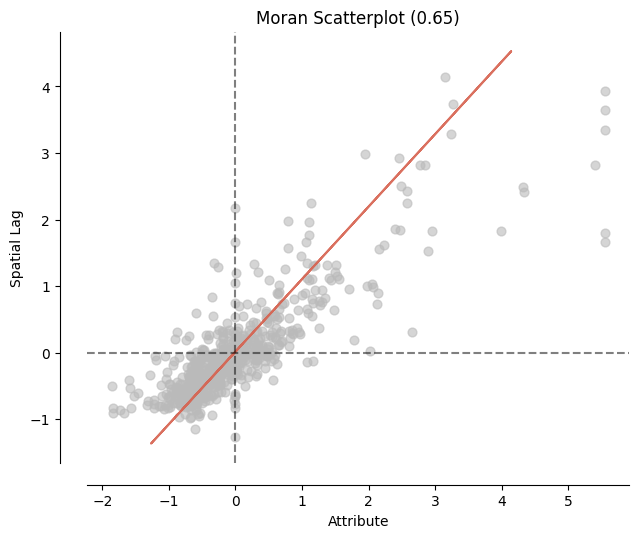

In [ ]:
mi1 = esda.Moran(gdf_copy['median_house_value'], w_queen1)
mi1.I
mi1.p_sim
moran_scatterplot(mi1);

print(f"Moran's I: {mi1.I}")
print(f"Moran's I (p_value): {mi1.p_sim}")

The value of Moran's I is 0.6466, which is closer to 1. This suggests positive spatial autocorrelation, meaning that areas with similar values of "median_house_value" are clustered together in space.
There is a positive and relatively strong spatial autocorrelation. That indicates that high (low) values of Median House Value are surrounded by high (low) values of Median House Value, and viceversa. The metric is "consistent" over space.

The p-value associated with Moran's I is 0.001, which is very low. This low p-value suggests that the observed positive spatial autocorrelation is statistically significant, indicating that the clustering of similar median house values is unlikely to be due to random chance.

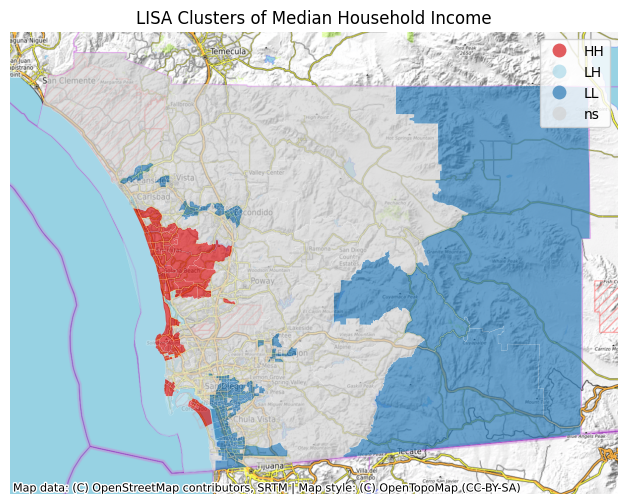

In [ ]:
lisa1 = esda.Moran_Local(gdf_copy['median_house_value'], w_queen1)
# Break observations into significant or not
gdf_copy['significant'] = lisa1.p_sim < 0.05
# Store the quadrant they belong to
gdf_copy['quadrant'] = lisa1.q

# Set up figure and axis
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Display the LISA clusters
lisa_cluster(lisa1, gdf_copy, ax=ax, alpha=0.7)

cx.add_basemap(ax, crs=gdf_copy.crs, source=cx.providers.OpenTopoMap, zoom=10)

ax.set_axis_off()
plt.title('LISA Clusters of Median Household Income')
plt.show()

In [ ]:
#lisa_mapping = {1:'HH', 2:'LH', 3:'LL', 4:'HL'}
# Replace non-significant values with 'ns'
gdf_copy.loc[~gdf_copy['significant'], 'quadrant'] = 'ns'

cluster_counts1 = gdf_copy['quadrant'].value_counts()

# Print the counts
print("LSOAS in each cluster:")
print(cluster_counts1)

LSOAS in each cluster:
quadrant
ns    405
3     146
1      69
2       8
Name: count, dtype: int64


1. HH: 69 hotspots (red areas in the LISA map)
2. LH: 8  spatial outliers (light blue)
3. LL: 146 coldspots (blue areas)
4. HL: 0 spatial outliers (orange areas)
5. ns: 405 not significant (grey area)

In this case, hotspots (coldspots) indicate neighborhoods with high (low) Median House Value surrounded by neighborhoods with high (low) Median House Value as well. This is the majority of the neighbors identified as significant confirming the global pattern from Moran's plot.

The spatial outliers (Low-High) are neighborhoods that have a low MHV, surrounded by neighborhoods with high MHV index. By definition, these neighborhoods are close to the hotspots.
The spatial outliers (High-Low) are neighborhoods that have a high MHV, surrounded by neighborhoods with low MHI index.

Large peripheral areas in the east are cold spots, while hot spots are concentrated near the coast on the suburbs of San Diego. Most of the county is not signifacant.

# Part II - Common

1. Visualize the dataset appropriately and discuss why you have taken your specific approach
2. Use DBSCAN to identify areas of the city with a high density of points, which we will call areas of interest (AOI). In completing this, answer at least the following questions:
- What parameters have you used to run DBSCAN? Why?
- What do the clusters help you learn about areas of interest in the city?
- Name one example of how these AOIs can be useful for the city. You can take the perspective of an urban planner, a policy maker, an operational practitioner (e.g. police, trash collection), an urban entrepreneur, or any other role you envision.

Data was downloaded using [Data Export Tool](https://acleddata.com/data-export-tool/).

[Ukraine - Conflict Events](https://data.humdata.org/dataset/ukraine-acled-conflict-data): A weekly dataset providing the total number of reported political violence events and fatalities in Ukraine broken down by month. Political violence events include ACLED’s battles, violence against civilians, and explosions/remote violence event types, as well as the mob violence sub-event type of the riots event type.

Dates used for the analyses: 24. February 2022 - 9. December 2023

The dataset includes 80865 rows = which means 80865 violence events.

In [ ]:
# https://data.humdata.org/visualization/ukraine-humanitarian-operations/?layer=conflict_events
filepath = os.path.join('data', '2022-02-24-2023-12-09-Europe-Ukraine.csv')

df1 = pd.read_csv(filepath, sep =',')

print(type(df1))
print(df1.shape)
df1.head()

<class 'pandas.core.frame.DataFrame'>
(80865, 31)


event_id_cnty        event_date  year  time_precision       disorder_type  \
0     UKR139474  08 December 2023  2023               1  Political violence   
1     UKR139475  08 December 2023  2023               1  Political violence   
2     UKR139476  08 December 2023  2023               1  Political violence   
3     UKR139477  08 December 2023  2023               1  Political violence   
4     UKR139478  08 December 2023  2023               1  Political violence   

                   event_type                     sub_event_type  \
0                     Battles                        Armed clash   
1                     Battles                        Armed clash   
2  Explosions/Remote violence  Shelling/artillery/missile attack   
3  Explosions/Remote violence  Shelling/artillery/missile attack   
4  Explosions/Remote violence  Shelling/artillery/missile attack   

                              actor1  \
0  Military Forces of Russia (2000-)   
1  Military Forces of Russia (2000-)   
2  Military Forces of Russia (2000-)   
3  Military Forces of Russia (2000-)   
4  Military Forces of Russia (2000-)   

                                 assoc_actor_1  inter1  ...     location  \
0                                          NaN       8  ...    Andriivka   
1  Military Forces of Russia (2000-) Air Force       8  ...     Avdiivka   
2                                          NaN       8  ...     Berdychi   
3                                          NaN       8  ...    Bilohiria   
4                                          NaN       8  ...  Bilohorivka   

  latitude  longitude  geo_precision  \
0  48.5008    37.9680              2   
1  48.1394    37.7497              2   
2  48.1936    37.6405              1   
3  47.5268    36.0004              1   
4  48.9259    38.2467              1   

                                              source    source_scale  \
0  Ministry of Defence of Russia; Ministry of Def...  Other-National   
1  Institute for the Study of War; Ministry of De...  Other-National   
2                     Ministry of Defence of Ukraine           Other   
3                                     Suspilne Media        National   
4                     Ministry of Defence of Ukraine           Other   

                                               notes fatalities tags  \
0  On 8 December 2023, Russian forces clashed wit...          1  NaN   
1  On 8 December 2023, Russian forces clashed wit...          0  NaN   
2  On 8 December 2023, Russian forces shelled Ber...          0  NaN   
3  On 8 December 2023, Russian forces shelled Bil...          0  NaN   
4  On 8 December 2023, Russian forces shelled Bil...          0  NaN   

    timestamp  
0  1702407967  
1  1702407967  
2  1702407967  
3  1702407967  
4  1702407967  

[5 rows x 31 columns]

In [ ]:
ukr = gpd.GeoDataFrame(df1, geometry=gpd.points_from_xy(df1['longitude'], df1['latitude']))
ukr = ukr.set_crs('epsg:4326')

For better understanding the data lets have a look at pie chart for event types:

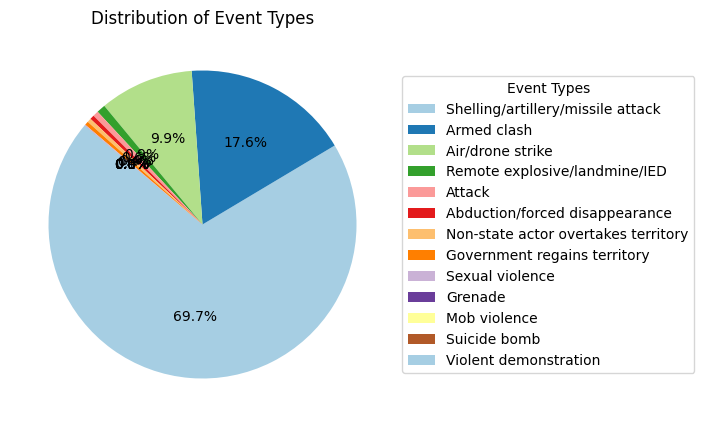

In [ ]:
event_type_counts = ukr['sub_event_type'].value_counts()

# Create a pie chart
plt.figure(figsize=(5, 5))
plt.pie(event_type_counts, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.legend(event_type_counts.index, title='Event Types', bbox_to_anchor=(1, 0.5), loc='center left')
plt.title('Distribution of Event Types')
plt.show()

70 % of all acts of violence are Shelling/artillery/missile attack. The second largest group (18%) is Armed clash. The third largest group by number of events is Air/drone strike (10%). The rest events (such as attack, remote explosive etc.) have less than 3%.

In [ ]:
# Choose an appropriate UTM zone for Ukraine (e.g., UTM Zone 35)
utm_zone = 35
ukr = ukr.to_crs(f'EPSG:326{utm_zone}')

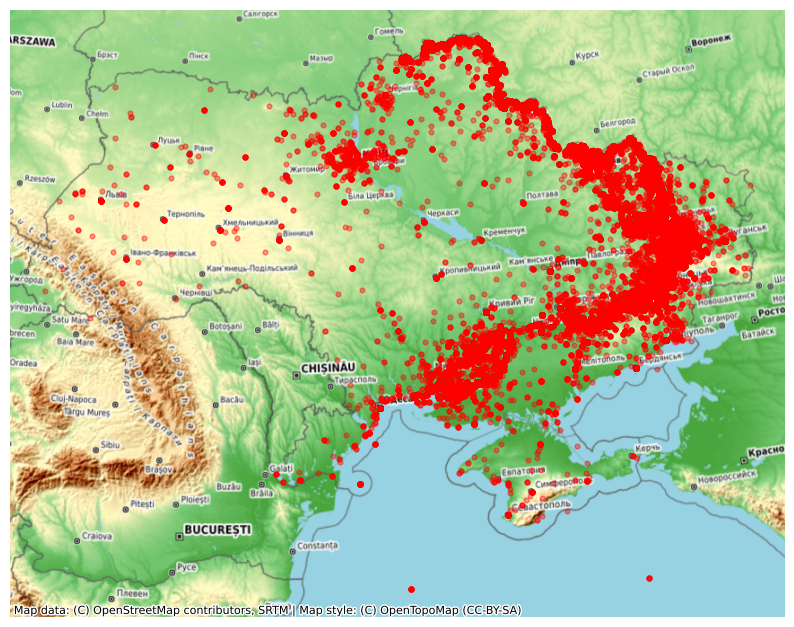

In [ ]:
f, ax = plt.subplots(1, figsize=(10, 10))
ukr.plot(ax=ax, alpha=0.4, color='red', markersize=12)
cx.add_basemap(ax=ax, crs=ukr.crs, source=cx.providers.OpenTopoMap)

ax.set_axis_off()
plt.show()

This map shows all the points of this dataset, representing all the recorded locations of acts of violence against Ukrainians on the territory of Ukraine for 24. February 2022 - 9. December 2023.

As can be seen from the map, a high concentration of points is in large cities such as Kyiv, Chernihiv, Kharkiv and the eastern part of the country, where the main military operations are concentrated along the frontline and near the northern and north-eastern border. However, it should be noted that acts of violence occur in all parts of Ukraine, even in the Black Sea.

In [ ]:
# Create a GeoDataFrame with point geometries
ukr1 = gpd.GeoDataFrame(df1, geometry=gpd.points_from_xy(df1['longitude'], df1['latitude']))

# Set the CRS to EPSG:4326
ukr1 = ukr1.set_crs('epsg:4326')

pts = gpd.points_from_xy(
    ukr["longitude"],
    ukr["latitude"],
    crs="EPSG:4326"
)

pts = gpd.GeoDataFrame({"geometry": pts}).to_crs(epsg=6381)
# Extract coordinates from point objects into columns
ukr["X_metres"] = pts.geometry.x
ukr["Y_metres"] = pts.geometry.y

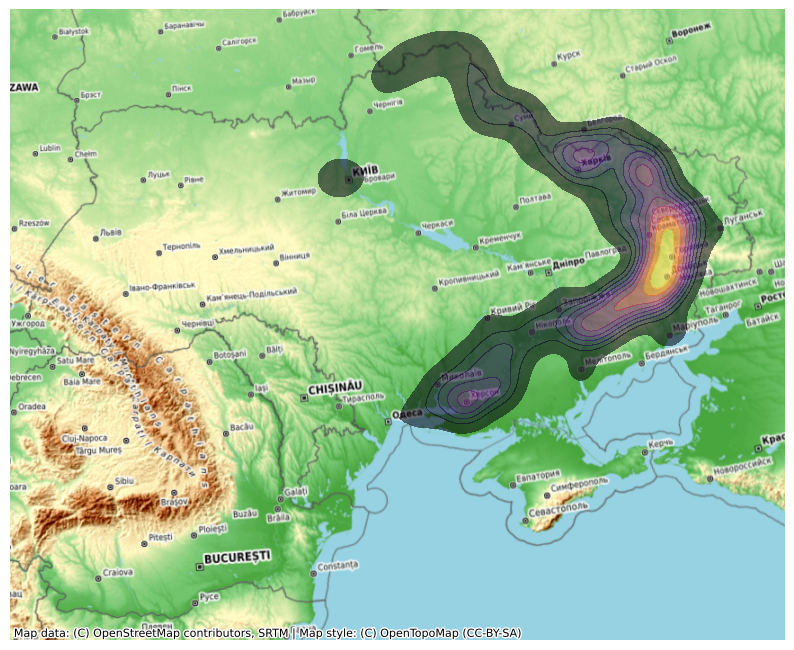

In [ ]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(10, 10))
ax.set_aspect('equal')

# Creates a Kernel Density Estimate (KDE) plot using Seaborn.
sns.kdeplot(
    x="X_metres",           # Specifies the 'x' column from 'db' for the x-axis values.
    y="Y_metres",           # Specifies the 'y' column from 'db' for the y-axis values.
    data=ukr,         # Sets 'db' as the data source for the plot.
    n_levels=10,     # Sets the number of contour levels (50 levels for the density plot).
    fill=True,       # Fills the contours for a more visual density representation.
    alpha=0.55,      # Sets the transparency of the fill (55% transparency).
    cmap="inferno", # Uses the reversed 'viridis' colormap for coloring the plot.
)
# Add basemap
#cx.add_basemap(ax, crs=ukr.crs, source=cx.providers.OpenStreetMap.Mapnik)
cx.add_basemap(ax, crs=ukr.to_crs(epsg=6381).crs, source=cx.providers.OpenTopoMap)
# Remove axes
ax.set_axis_off()
plt.show()

For better visibility, a Kernel Density Estimate (KDE) was also made.
We used 10 levels for the density graph. Yellow shows the highest density of points.
The highest level is the area in eastern Ukraine near Donetsk and Horlivka. Kharkiv and Kherson also have high scores. In the north and north-east of Ukraine, there is a clear concentration of events along the border. In the east and southeast, this line has shifted away from the border and into the depths of Ukraine as territory has been occupied.

In [ ]:
# Initialize DBSCAN clustering.
algo = DBSCAN(
    eps=1000,        # Maximum distance for neighborhood points
    min_samples=100  # Minimum number of samples for a core point
)
algo.fit(ukr[["X_metres", "Y_metres"]])

ukr['cluster_label'] = pd.Series(algo.labels_, index=ukr.index)
ukr['cluster_label'].value_counts()

cluster_label
-1      32651
 22       822
 1        676
 33       632
 73       605
        ...  
 208      103
 176      101
 93       101
 94       101
 212      101
Name: count, Length: 214, dtype: int64

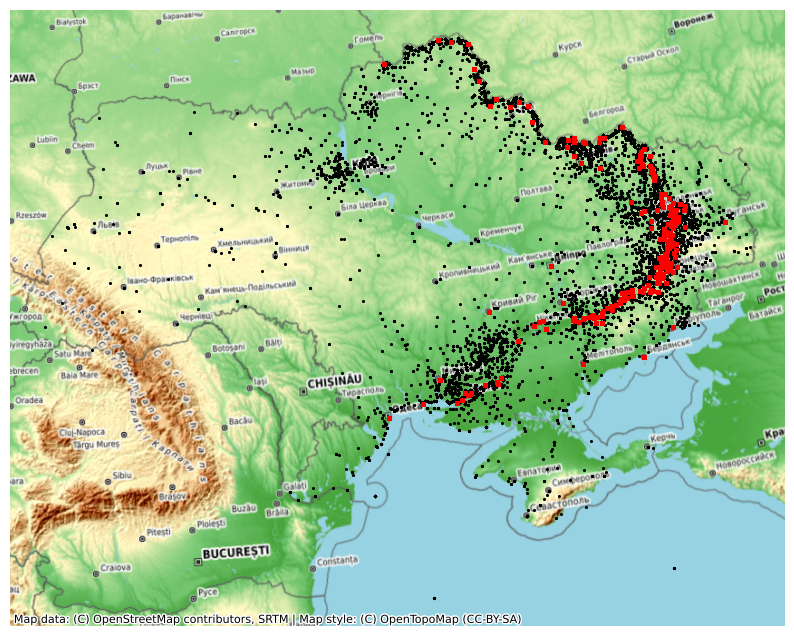

In [ ]:
# Setup figure and axis
f, ax = plt.subplots(1, figsize=(10, 10))

# Create subset of the dataframe to split noise and cluster(ed) points
noise_points = ukr.loc[ukr['cluster_label']==-1]
cluster_points = ukr.loc[ukr['cluster_label']!=-1]

# Plot noise in grey
ax.scatter(
    noise_points["X_metres"],
    noise_points["Y_metres"],
    c='black',
    s=5,
    linewidth=0
)

# Plot cluster(ed) points with a color for each cluster
ax.scatter(
    cluster_points["X_metres"],
    cluster_points["Y_metres"],
    #c=cluster_points["cluster_label"],
    c='red',
    s=12,
    linewidth=0
)

#add a basemap
cx.add_basemap(ax=ax, crs=ukr.to_crs(epsg=6381).crs, source=cx.providers.OpenTopoMap)

# Remove axes
ax.set_axis_off()

# Display the figure
plt.show()

The next step was to perform DBSCAN. For this purpose, the parameters eps=1000 (maximum distance to neighbouring points 1000m = 1 km) and min_samples=100 (Minimum number of samples for a core point 100) were used. This means that red marks on the map indicate clusters, i.e. places within 1 km of which there were at least 100 acts of violence.

As mentioned earlier, the results of this scan revealed the main hotspots. A very high concentration of clusters is observed in the east of Ukraine (along the frontline), where the main warfare is taking place. There is also a concentration of clusters in the north near the border and in the south near Odesa and Kherson. It is also noticeable that some of the clusters in the south extend along the Dnipro River.

What do the clusters help to learn about areas of interest?

Clustering helps to study different things, depending on the goals and context. For example:
- Spatial Distribution of Features (how events are distributed across the country)
- Hotspots and Coldspots
- Urban Planning and Development
- Public Health and Safety
- Resource Allocation and so on...

In our case, the task was to cover the events in Ukraine during the mentioned period and assess the scale and spread of acts of violence in the country, in other words, to see the picture globally and stay informed. For example, where the high concentration of events is located, in which regions, and to speculate on what this is due to and how to counteract it in the future.

AOIs (areas of interests) can be useful for:
- Humanitarian Organizations - humanitarian organizations can use the insights to plan and target aid distribution. They can prioritize assistance to areas most affected by political violence, ensuring that resources reach the communities in greatest need.
- Researchers - researchers can use the clustering results for in-depth studies on the root causes and dynamics of political violence. This can contribute to academic understanding and the development of theories related to conflict resolution and prevention.
- Urban Planner - urban planners can use the identified clusters to understand the spatial distribution of conflict events. If certain areas consistently experience political violence, planners may reconsider urban development plans in those regions. They might avoid constructing critical infrastructure or residential areas in high-conflict zones, contributing to safer and more sustainable urban development.

# Part III - Choose your own adventure

Create a regionalisation and interpret the results. In the process, answer at least the following questions:

- How is the city partitioned by your data?
- What do you learn about the geography of the city from the regionalisation?
- What would one useful application of this regionalization in the context of urban policy?

This part of the project used the Toronto Socio Economic dataset.

[Socio-economic characteristics of Toronto neighborhoods](https://darribas.org/gds_course/_downloads/a2bdb4c2a088e602c3bd6490ab1d26fa/toronto_socio-economic.gpkg): This dataset contains a set of polygons representing the official neighborhoods, as well as socio-economic information attached to each neighborhood.

In [ ]:
toronto = gpd.read_file("https://darribas.org/gds_course/_downloads/a2bdb4c2a088e602c3bd6490ab1d26fa/toronto_socio-economic.gpkg")
toronto.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   _id                   140 non-null    int64   
 1   AREA_NAME             140 non-null    object  
 2   Shape__Area           140 non-null    float64 
 3   neighbourhood_name    140 non-null    object  
 4   population2016        140 non-null    float64 
 5   population_sqkm       140 non-null    float64 
 6   pop_0-14_yearsold     140 non-null    float64 
 7   pop_15-24_yearsold    140 non-null    float64 
 8   pop_25-54_yearsold    140 non-null    float64 
 9   pop_55-64_yearsold    140 non-null    float64 
 10  pop_65+_yearsold      140 non-null    float64 
 11  pop_85+_yearsold      140 non-null    float64 
 12  hh_median_income2015  140 non-null    float64 
 13  canadian_citizens     140 non-null    float64 
 14  deg_bachelor          140 non-null    float64 
 15

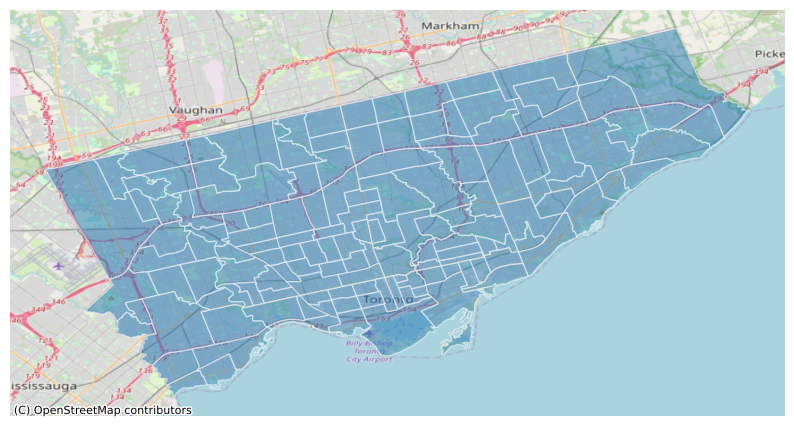

In [ ]:
#visualization
f, ax = plt.subplots(1, figsize=(10, 10))
toronto.plot(ax=ax, alpha=0.5, edgecolor='white')
cx.add_basemap(ax=ax, crs=toronto.crs, source=cx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()
plt.show()

In [ ]:
w = weights.KNN.from_dataframe(toronto, k=5)
n_clusters = 5

#normalize features
scaler = MinMaxScaler()
X = toronto[['canadian_citizens', 'deg_bachelor', 'employed', 'hh_median_income2015']]
X = scaler.fit_transform(X)

#cluster (define and fit)
sagg = cluster.AgglomerativeClustering(n_clusters=n_clusters, connectivity=w.sparse)
sagg.fit(X)

#add cluster label (result) to original df
toronto['cluster_label'] = sagg.labels_

#print results
print(toronto['cluster_label'].value_counts().sort_index())
toronto.groupby('cluster_label')[['canadian_citizens', 'deg_bachelor', 'employed', 'hh_median_income2015']].mean()

cluster_label
0    24
1    92
2    17
3     1
4     6
Name: count, dtype: int64


canadian_citizens  deg_bachelor      employed  \
cluster_label                                                  
0                   14212.500000   3978.541667  10469.583333   
1                   10905.597826   2948.423913   7883.858696   
2                   21615.294118   5885.882353  15026.470588   
3                   51170.000000  27280.000000  48470.000000   
4                   16950.833333   6763.333333  13488.333333   

               hh_median_income2015  
cluster_label                        
0                       8428.333333  
1                       6433.532609  
2                      11764.411765  
3                      40750.000000  
4                      13002.500000

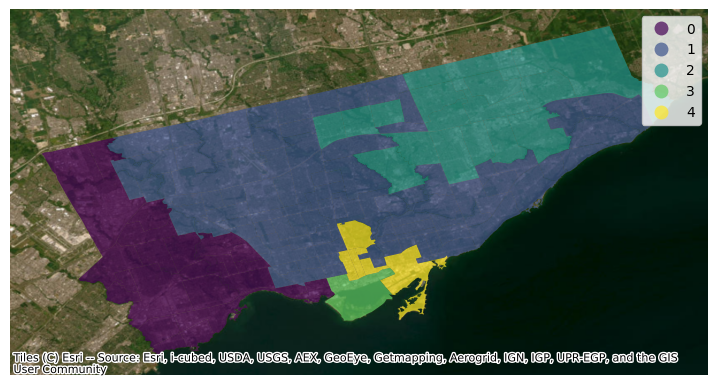

In [ ]:
#visualization
f, ax = plt.subplots(1, figsize=(9, 9))
toronto.plot(ax=ax, column='cluster_label', categorical=True, legend=True, linewidth=0.5, alpha=0.7, cmap='viridis')
cx.add_basemap(ax=ax, crs=toronto.crs, source=cx.providers.Esri.WorldImagery)
ax.set_axis_off()
plt.show()

**Toronto** is the most populous city in Canada and the capital city of the Canadian province of Ontario. It is the fourth-most populous city in North America. Toronto is an international centre of business, finance, arts, sports and culture, and is one of the most multicultural and cosmopolitan cities in the world. The diverse population of Toronto reflects its current and historical role as an important destination for immigrants to Canada. About half of its residents were born outside of Canada and over 200 ethnic origins are represented among its inhabitants.

Given that Toronto is such a multicultural city, we were interested in regionalising it by these indicators and seeing what regions can be identified in the city and how they are characterised.

We regionalised Toronto using the following indicators:
- *Canadian citizens*,
- *Degree Bachelor*,
- *Employed*,
- *Household median income 2015*.

The number of clusters was chosen to be 5.


- **Cluster 0** is the eastern part of Toronto, which is characterised by average indicators except for deg_bachelor, which is one of the lowest.
- **Cluster 1** occupies the largest part of Toronto and has the lowest level of all indicators of all clusters
- **Cluster 2** is the north-western part of the city with average indicators, but higher than cluster 0.
- **Сluster 3** has a high level of all indicators - average income, employment, Canadian citizens, and people with a degree. This cluster is located on the coast in downtown Toronto.
- **Сluster 4** is located next to it (a large number of Canadian citizens, medium employment, and a sufficient level of income).
The other clusters have lower scores than the two previously mentioned.


What do you learn about the geography of the city from the regionalisation?

A significant number of people with education and Canadian citizenship are concentrated in the central part of Toronto near the coast. Toronto is known as a city where many foreigners live. This characterises Cluster 1, which has a low citizenship rate and covers most of the city.

What would one useful application of this regionalization in the context of urban policy?

Community Engagement: Localized Engagement Strategies (Regionalization fosters community engagement by acknowledging the distinct identities and concerns of different regions. Urban policies can implement community outreach programs that involve residents in decision-making processes)


# Part IV - Going beyond!

- Provide some analyses where you spatially join a new data set
- Fit a spatial regression model (and potentially perform spatial feature engineering)
- You can find more ideas by looking into the accompanying book

For this part we did a **Spatial regression analysis** and in the end also the analysis of AirBnB (creating an interactive map of Amsterdam) that was based on the article by [JUAN VICENTE PELUSO](https://www.kaggle.com/code/jvpeluso/nyc-airbnb-open-data-analysis).

To do this, we used information from the website [Inside AirBnB](http://insideairbnb.com/get-the-data/).

**Amsterdam** is one of the most tourist cities in Europe, which is why we were interested in analysing AirBnB apartments and creating a regression model.

## Spatial Regression
Regression (and prediction more generally) provides us a perfect case to examine how spatial structure can help us understand and analyze our data.

In [ ]:
!pip install osmnx
!pip install folium matplotlib mapclassify

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.8/102.8 kB 4.5 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [ ]:
import os
import esda
import pandas as pd
import geopandas as gpd
import seaborn as sns
import contextily as cx
import matplotlib.pyplot as plt
from sklearn import cluster

from pysal.lib import weights
from pysal.lib import examples
from splot.esda import moran_scatterplot, lisa_cluster
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

import importlib

from pysal.model import spreg
from pysal.explore import esda
from scipy import stats
import statsmodels.formula.api as sm
import numpy as np
sns.set(style="whitegrid")
import osmnx as ox

In [ ]:
filepath = os.path.join('data', 'amsterdam_listing.csv')
fullDF = pd.read_csv(filepath, sep =',')
fullDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8739 entries, 0 to 8738
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            8739 non-null   int64  
 1   listing_url                                   8739 non-null   object 
 2   scrape_id                                     8739 non-null   int64  
 3   last_scraped                                  8739 non-null   object 
 4   source                                        8739 non-null   object 
 5   name                                          8739 non-null   object 
 6   description                                   0 non-null      float64
 7   neighborhood_overview                         5346 non-null   object 
 8   picture_url                                   8739 non-null   object 
 9   host_id                                       8739 non-null   i

In [ ]:
query = {'city': 'Amsterdam'}
# get the boundaries of the place (add additional buffer around the query)
boundaries = ox.geocode_to_gdf(query, buffer_dist=5000)

/tmp/ipykernel_795/855848869.py:3: UserWarning: The buffer_dist argument has been deprecated and will be removed in a future release. Buffer your results directly, if desired.
  boundaries = ox.geocode_to_gdf(query, buffer_dist=5000)


For better visibility, we did a **Spatial Join** and plotted a map, where you can see all available AirBnB's apartments and the borders of the city of Amsterdam (from the ox library).

In [ ]:
# Create a GeoDataFrame
fullDF["geometry"] = gpd.points_from_xy(fullDF["longitude"], fullDF["latitude"])
data = gpd.GeoDataFrame(fullDF, crs="epsg:4326")

# Filter geographically
data = gpd.sjoin(data, boundaries[["geometry"]])
data = data.reset_index(drop=True)

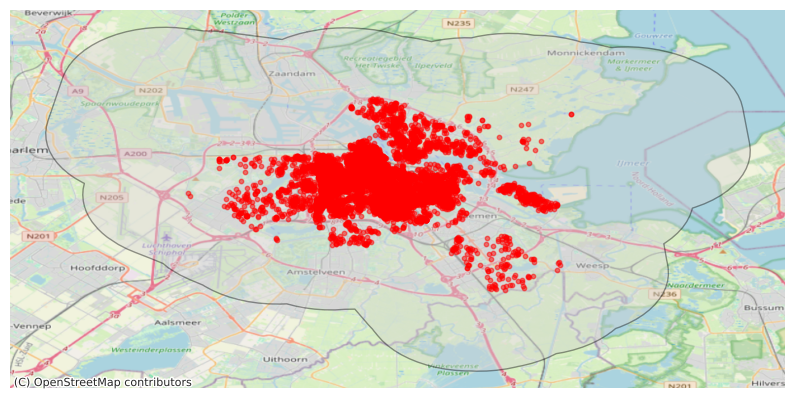

In [ ]:
# Plot the GeoDataFrame's geometry with a basemap
fig, ax = plt.subplots(figsize=(10, 10))
boundaries.plot(ax=ax, color='lightgray', edgecolor='black', alpha=0.4)  # Plot administrative boundaries
data.plot(ax=ax, color='red', markersize=10, alpha=0.5)  # Plot the GeoDataFrame's geometry on top

# Add basemap using contextily
cx.add_basemap(ax, crs=data.crs, source=cx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()  # Hide the axes

plt.show()

In [ ]:
# variables for regression
explanatory_vars = ['host_listings_count', 'minimum_nights', 'maximum_nights', 'beds', 'review_scores_rating']

In [ ]:
def has_2bath(a):
    if pd.notnull(a) and '2' in str(a):
        return 1
    else:
        return 0

data['2bath'] = data['bathrooms_text'].apply(has_2bath)

In [ ]:
# Remove dollar sign and commas, then convert to float
data["price"] = data["price"].replace('[\$,]', '', regex=True).astype(float)
data["log_price"] = np.log(data["price"] + 0.000001)

In [ ]:
all_model_attributes = ["price"] + explanatory_vars
has_nans = False
for attr in all_model_attributes:
    if data[attr].hasnans:
        has_nans = True
print("Has missing values:", has_nans)

Has missing values: True


In [ ]:
# delete the missing values
data = data.dropna(subset=all_model_attributes).copy()

### Spatially lagged exogenous regressors (WX)

The first and most straightforward way to introduce space is by “spatially lagging” one of the explanatory variables.

Typically, we want to determine the spatial lag of variables that we think might affect the price of a house in a particular location. For example, we may believe that having 2 bathrooms is a visual advantage. If this is the case, then properties surrounded by other properties with this feature may, ceteris paribus, be more expensive. To calculate the number of bathrooms around each property, we can construct an alternative weighting matrix.

In [ ]:
# Create weigts
w_bath = weights.KNN.from_dataframe(data, k=8)
# Assign spatial lag based on the pool values
lagged = data.assign(w_bath=weights.spatial_lag.lag_spatial(w_bath, data['2bath'].values))
lagged.head()

/home/vscode/.local/lib/python3.8/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  warnings.warn(message)


id                                      listing_url  \
0             9060873             https://www.airbnb.com/rooms/9060873   
1             1427610             https://www.airbnb.com/rooms/1427610   
2             4829273             https://www.airbnb.com/rooms/4829273   
4  864176551965684805  https://www.airbnb.com/rooms/864176551965684805   
5            44456510            https://www.airbnb.com/rooms/44456510   

        scrape_id last_scraped           source  \
0  20231212015436   2023-12-12      city scrape   
1  20231212015436   2023-12-12  previous scrape   
2  20231212015436   2023-12-12      city scrape   
4  20231212015436   2023-12-12      city scrape   
5  20231212015436   2023-12-12  previous scrape   

                                                name  description  \
0  Condo in Amsterdam · ★4.60 · 1 bedroom · 1 bed...          NaN   
1  Home in Amsterdam · ★5.0 · 2 bedrooms · 2 beds...          NaN   
2  Rental unit in Amsterdam · ★4.71 · 1 bedroom ·...          NaN   
4  Home in Amsterdam · ★5.0 · 2 bedrooms · 2 beds...          NaN   
5  Rental unit in Amsterdam · ★4.86 · 1 bedroom ·...          NaN   

  neighborhood_overview                                        picture_url  \
0                   NaN  https://a0.muscache.com/pictures/miso/Hosting-...   
1                   NaN  https://a0.muscache.com/pictures/8d855b40-ba50...   
2                   NaN  https://a0.muscache.com/pictures/104943349/73c...   
4                   NaN  https://a0.muscache.com/pictures/miso/Hosting-...   
5                   NaN  https://a0.muscache.com/pictures/d15b6792-f57a...   

     host_id  ... calculated_host_listings_count  \
0   47265643  ...                              1   
1    7677579  ...                              1   
2   15049236  ...                              1   
4  508937163  ...                              1   
5   97096943  ...                              2   

  calculated_host_listings_count_entire_homes  \
0                                           1   
1                                           1   
2                                           1   
4                                           1   
5                                           2   

  calculated_host_listings_count_private_rooms  \
0                                            0   
1                                            0   
2                                            0   
4                                            0   
5                                            0   

  calculated_host_listings_count_shared_rooms reviews_per_month  \
0                                           0              0.38   
1                                           0              0.15   
2                                           0              0.51   
4                                           0              0.76   
5                                           0              0.25   

                   geometry index_right 2bath log_price w_bath  
0  POINT (4.91753 52.35656)           0     0  5.446737    1.0  
1  POINT (4.80351 52.38277)           0     1  4.787492    0.0  
2  POINT (4.93354 52.36379)           0     0  5.135798    1.0  
4  POINT (4.93407 52.36379)           0     0  5.579730    2.0  
5  POINT (4.86689 52.36486)           0     0  5.075174    1.0  

[5 rows x 80 columns]

In [ ]:
# Add bath to the explanatory variables
extended_vars = explanatory_vars + ["2bath", "w_bath"]

m2 = spreg.OLS(lagged[['log_price']].values, lagged[extended_vars].values,
               name_y = 'log_price', name_x = extended_vars)

In [ ]:
print(m2.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   log_price                Number of Observations:        7595
Mean dependent var  :      5.3065                Number of Variables   :           8
S.D. dependent var  :      0.5583                Degrees of Freedom    :        7587
R-squared           :      0.1747
Adjusted R-squared  :      0.1740
Sum squared residual:     1953.68                F-statistic           :    229.5005
Sigma-square        :       0.258                Prob(F-statistic)     :  1.301e-310
S.E. of regression  :       0.507                Log likelihood        :   -5620.683
Sigma-square ML     :       0.257                Akaike info criterion :   11257.365
S.E of regression ML:      0.5072                Schwarz criterion     :   11312.847

------------------------------------------------------------

- Dependent Variable is log_price.
- Number of Observations: 8371.
- Number of Variables: 7.

- The R-squared value of 0.1747 suggests that the model explains about 17.47% of the variance in the dependent variable.
- The coefficients indicate the impact of each independent variable on the dependent variable.
- The p-values associated with each coefficient help assess their statistical significance.

Neither the the number of listings the host has in total nor the minimum nights and maximum night have a significant effect on the final price. But the extra bed increase the final price around 12%. Similarly, the presence of a second additional bathroom increases the price by 35%. Review scores rating also increases the price by 39%.

Including a spatial weights object in the regression buys you an extra bit: the summary provides results on the diagnostics for spatial dependence. These are a series of statistics that test whether the residuals of the regression are spatially correlated, against the null of a random distribution over space.

Also, incidentally, the number of second bathrooms surrounding a property does not appear to have any significant effect on the price of a given property. This could be for a host of reasons: maybe AirBnb customers do not value this surrounding a property.

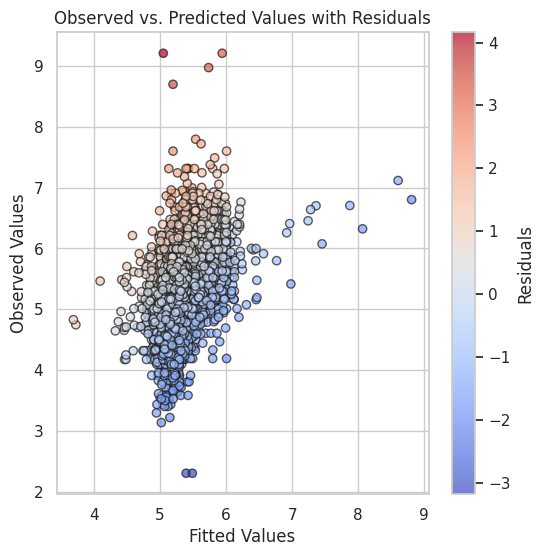

In [ ]:
# Get the fitted values and residuals from the model
fitted_values = m2.predy.flatten()
residuals = m2.u

# Create a scatterplot of observed versus predicted values
plt.figure(figsize=(6, 6))
plt.scatter(fitted_values, data['log_price'], c=residuals, cmap='coolwarm', edgecolors='k', alpha=0.7)
plt.title('Observed vs. Predicted Values with Residuals')
plt.xlabel('Fitted Values')
plt.ylabel('Observed Values')
plt.colorbar(label='Residuals')
plt.show()

We can visualize the results of spatial regression model using various diagnostic plots. One common way to assess spatial regression models is to plot the residuals and the fitted values.

- The x-axis represents the fitted (predicted) values from spatial regression model (fitted_values).
- The y-axis represents the observed values (data['log_price']).
- The color of the points represents the residuals. This scatterplot allows us to visually assess how well model is fitting the data. Each point in the scatterplot represents an observation in dataset.
The color of each point indicates the residual value for that observation. Residuals are the differences between the observed and predicted values.
-Blue points may represent observations where the model underpredicted (residuals are negative).
Red points may represent observations where the model overpredicted (residuals are positive).

Ideally, we want the points to be evenly scattered around a 45-degree line, and the color of the points (representing residuals) should not show a specific pattern.

Most of the points are concentrated in the region between 3 and 7 on the y-axis (observed values) and between 5 and 6 on the x-axis (fitted values).
This concentration suggests that, in general, the model is performing well in predicting values within this range.

## AirBnB Analysis (creating an interactive map)

In [ ]:
# Import summary dataset of Amsterdam Airbnb data in pandas dataframe
filepath = os.path.join('data', 'listings.csv')
fullDF = pd.read_csv(filepath, sep =',')

filepath = os.path.join('data', 'neighbourhoods.geojson')
# Read neighborhoods.geojson using geopandas
neighbourhoods = gpd.read_file(filepath)

fullDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8739 entries, 0 to 8738
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              8739 non-null   int64  
 1   name                            8739 non-null   object 
 2   host_id                         8739 non-null   int64  
 3   host_name                       8739 non-null   object 
 4   neighbourhood_group             0 non-null      float64
 5   neighbourhood                   8739 non-null   object 
 6   latitude                        8739 non-null   float64
 7   longitude                       8739 non-null   float64
 8   room_type                       8739 non-null   object 
 9   price                           8443 non-null   float64
 10  minimum_nights                  8739 non-null   int64  
 11  number_of_reviews               8739 non-null   int64  
 12  last_review                     78

First, let's see how the number of airbnbs is distributed across Amsterdam's districts.

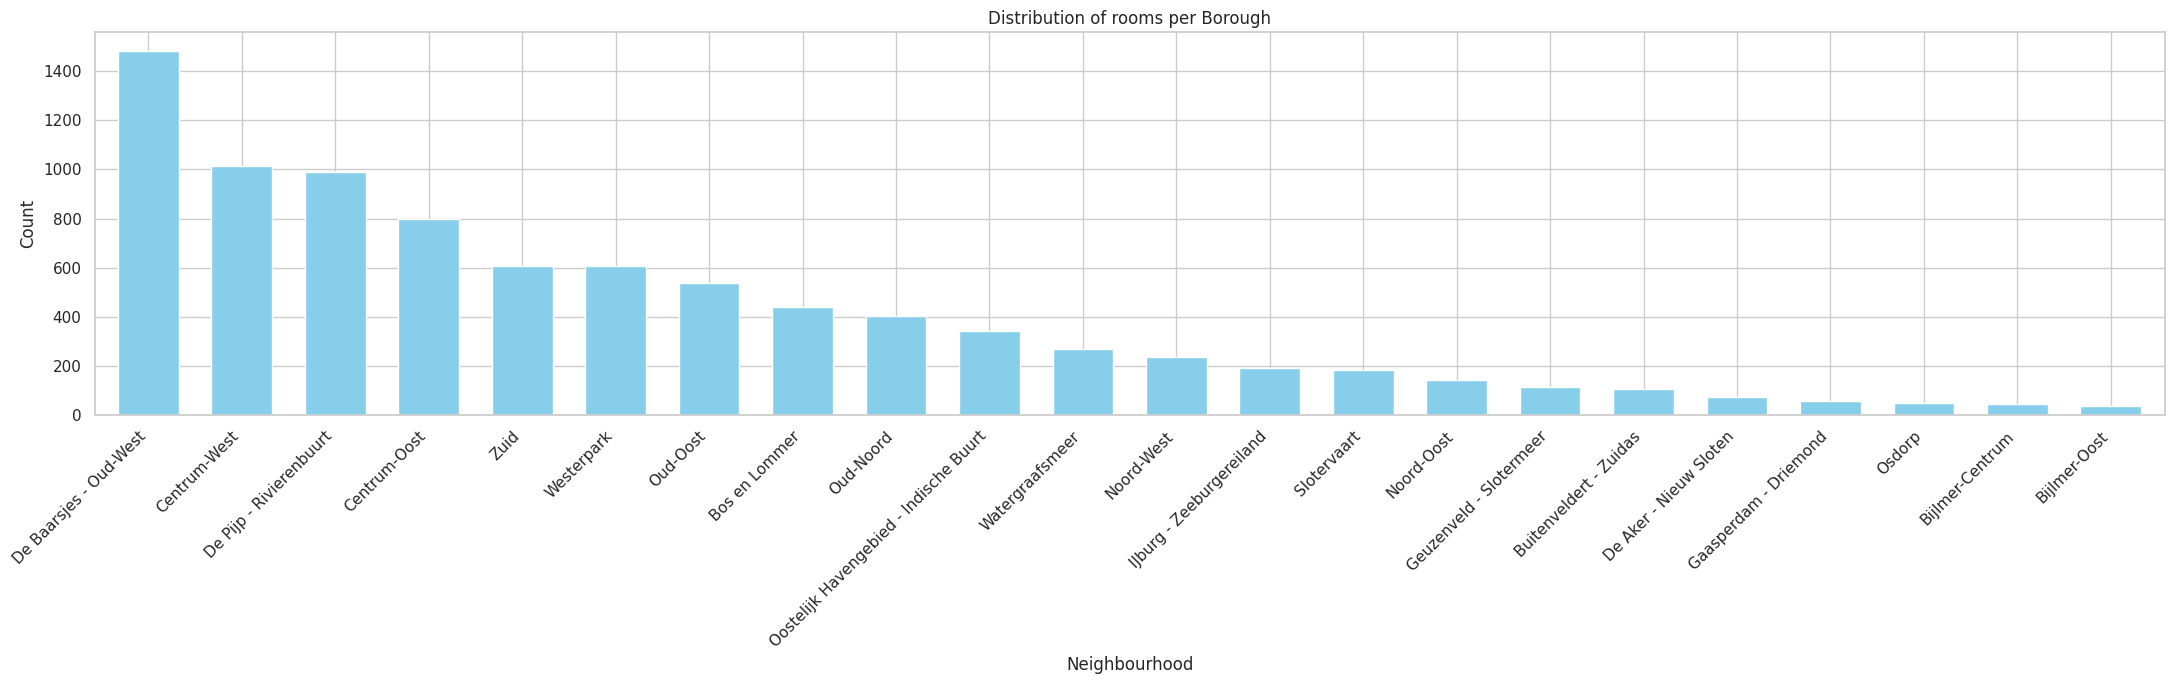

In [ ]:
neighbourhood_counts = fullDF['neighbourhood'].value_counts()

fig, ax = plt.subplots(figsize=(22, 7))

# Create the bar plot
neighbourhood_counts.plot(kind='bar', ax=ax, width=0.65, color='skyblue')

# Set labels and title
ax.set_xticklabels(neighbourhood_counts.index, rotation=45, ha='right')
ax.set_xlabel('Neighbourhood')
ax.set_ylabel('Count')
ax.set_title('Distribution of rooms per Borough')

plt.tight_layout()
plt.show()

The largest number is in De Baarsjes, in Centrum West and in De Pijp. All of them are multicultural neighbourhoods with a lot of cafes, hotels, restaurants and bars.

/tmp/ipykernel_795/1455594686.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tmpDF['neighbourhood'], rotation=45, ha='right')


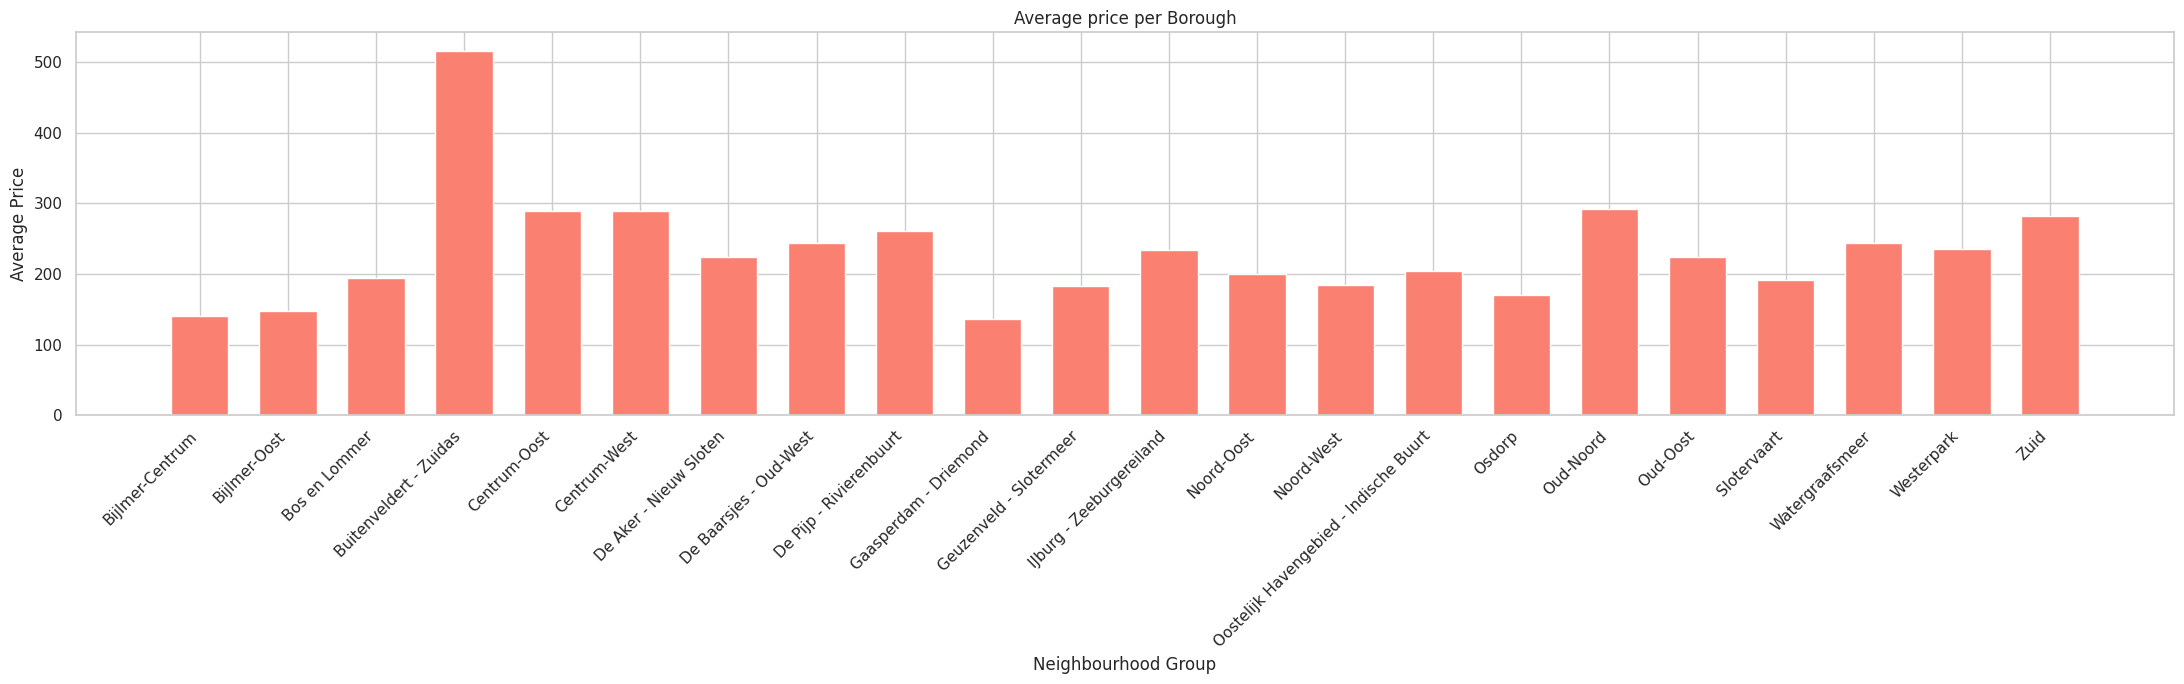

In [ ]:
tmpDF = fullDF.groupby('neighbourhood')['price'].mean().reset_index()
strTitle = 'Average price per Borough'

fig, ax = plt.subplots(figsize=(22, 7))

# Create the bar plot
ax.bar(tmpDF['neighbourhood'], tmpDF['price'], color='salmon', width=0.65)

# Set labels and title
ax.set_xticklabels(tmpDF['neighbourhood'], rotation=45, ha='right')
ax.set_xlabel('Neighbourhood Group')
ax.set_ylabel('Average Price')
ax.set_title(strTitle)

plt.tight_layout()
plt.show()

We have also determined the average price of accommodation by district and depicted it in a graph.
the highest price in the Buitenveldert district, Centrum, Oud Noord, Zuid.

In [ ]:
!pip install folium

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [ ]:
import folium
from folium.plugins import MarkerCluster
import numpy as np

In [ ]:
def foliumGJ(mMap, df, key, countV, lstColor,  aliases, vmin, vmax, name, step = 10):

    """ Function that create a choropleth map.

    Arguments
    ---------
    map:        Folium map
    df:         Dataframe
    key:        Key to use with the GeoJson
    countV:     Varible with the amount to be used with the colormap
    lstColor:   Color list to create the colormap
    aliases:    Aliases for the popup
    vmin, vmax: Min and Max for the colormap
    step:       Gradient steps for the colormap

    """

    colormap = folium.LinearColormap(colors = lstColor,
                                     vmin = vmin, vmax = vmax).to_step(step)
    folium.GeoJson(df[['geometry',key ,countV]],
                   name = name,
                   style_function = lambda x: {"weight" : 0.25, 'color':'black','fillColor':colormap(x['properties'][countV]), 'fillOpacity' : 0.55},
                   highlight_function = lambda x: {'weight': 0.75 , 'color':'black', 'fillOpacity' : 0.85},
                   smooth_factor=2.0,
                   tooltip=folium.features.GeoJsonTooltip(fields=[key,countV],
                                                          aliases=aliases,
                                                          labels=True)).add_to(mMap)

    return mMap

In [ ]:
# Create the map

mMap = folium.Map(location=[52.379189, 4.899431], zoom_start = 10, width = 600, height = 600, tiles='cartodbpositron')

# Create the data (rooms)
AMS = neighbourhoods.merge(fullDF.groupby('neighbourhood').count()['id'].reset_index(),
                          left_on='neighbourhood', right_on='neighbourhood', how='inner').fillna(0)

# Add geoJson density layer
mMap = foliumGJ(mMap, df = AMS, key = 'neighbourhood',
                countV = 'id', lstColor = ['#ffffcc','#fecc5c','#fd8d3c','#f03b20','#bd0026'],
                aliases = ['Neighborhood:','Airbnbs:'],
                vmin = 0, vmax = int(AMS['id'].max()),
                name = 'Airbnb places in Amsterdam')

# Create the data (prices)
tmpDF = fullDF.groupby('neighbourhood').agg({'price' : np.mean}).reset_index()
vMin = round(tmpDF['price'].min(),0)
vMax = round(tmpDF['price'].max(),0)
tmpDF['price'] = tmpDF['price'].map('{:,.2f}'.format)
tmpDF['price'] = tmpDF['price'].astype(float)

AMS_prices = neighbourhoods.merge(tmpDF, left_on='neighbourhood',
                            right_on='neighbourhood', how='inner').fillna(0)

# Add geoJson density layer
mMap = foliumGJ(mMap, df = AMS_prices, key = 'neighbourhood',
                countV = 'price', lstColor = ['#ffffcc','#cceeff','#4da6ff','#1a1aff','#000080'],
                aliases = ['Neighborhood:','Average Price:'],
                vmin = vMin, vmax = vMax, step = 5,
                name = 'Airbnb average price in Amsterdam')

# Add title and layer control
title_html = '''
             <h3 align="left" style="font-size:16px"><b>Amsterdam neighbourhoods (Airbnb places and average price)</b></h3>
             '''
mMap.get_root().html.add_child(folium.Element(title_html))
mMap.add_child(folium.map.LayerControl(collapsed=False))

# Show map
mMap

For this analysis, we used a new package with a plugin to build our own custom functions for creating choropleths.

The main task was to create an interactive choropleth that would demonstrate the distribution of apartments in Amsterdam depending on the district with a zoom function and a legend with control (displaying the number of apartments or prices, or both).
As you can see on the map, the central areas (especially near the canals) have high housing prices (blue). This is not the case for more remote areas on the outskirts of the city (yellow). the same trend is observed in the number of apartments.

To see the interactive Amsterdam map it is necessary to run the code above. Below there is an image how the map looks like:

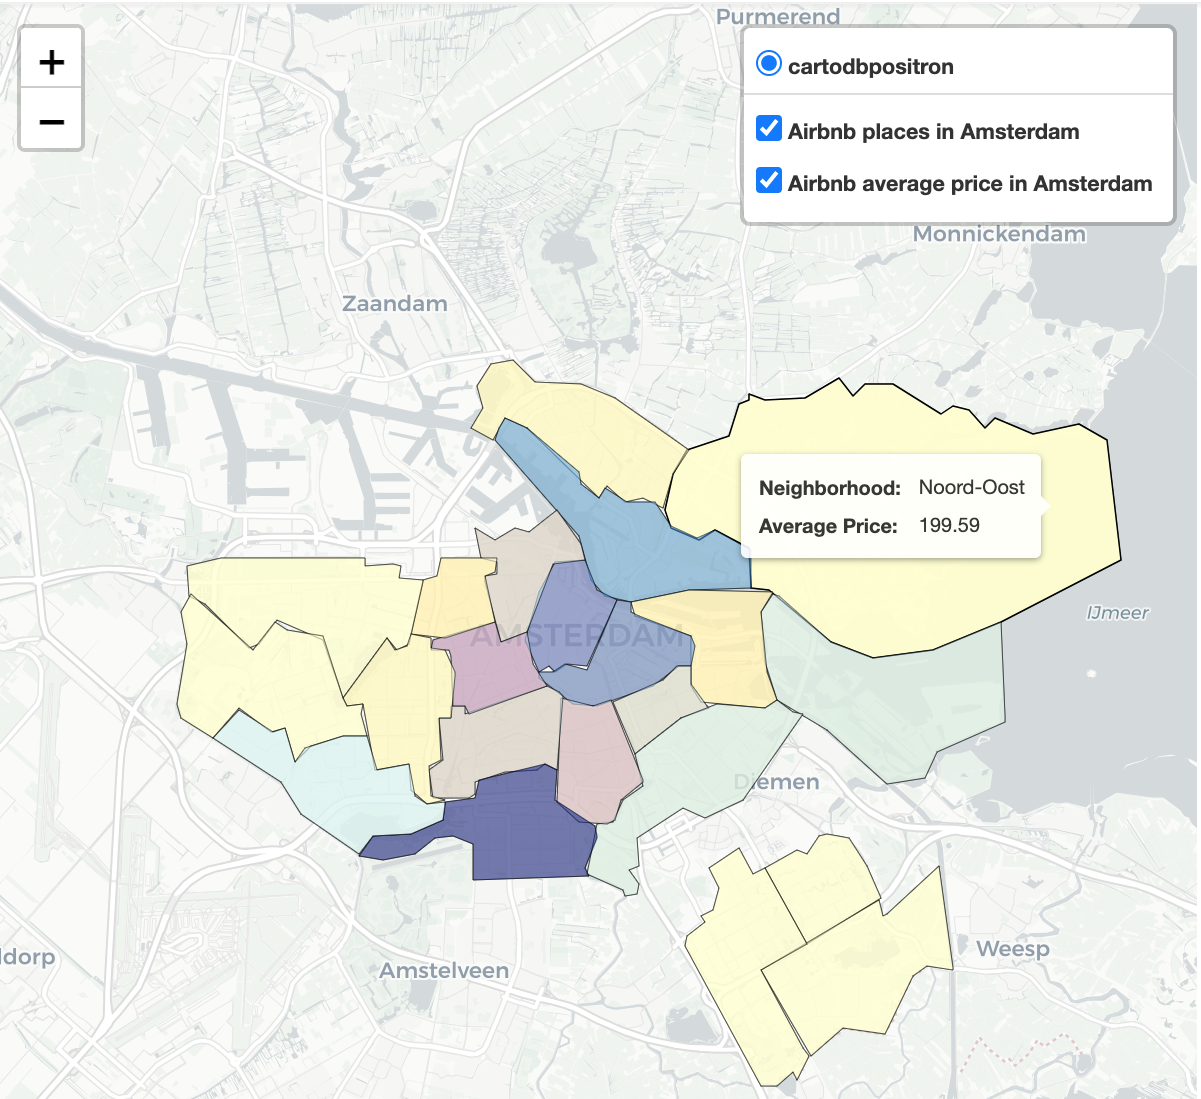

In [ ]:
from IPython.display import Image, display
display(Image(filename='data/map.png', width=500, height=400))

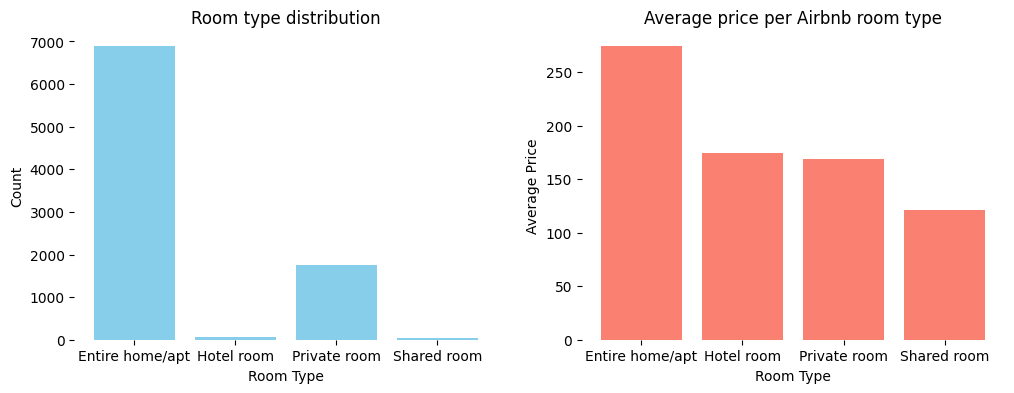

In [ ]:
fig1, axes = plt.subplots(1, 2, figsize=(12, 4))

# Create the data
tmpDF_count = fullDF.groupby('room_type').count()['id']
strTitle_count = 'Room type distribution'

# Plot figure for room type distribution
axes[0].bar(tmpDF_count.index, tmpDF_count, color='skyblue')
axes[0].set_title(strTitle_count)
axes[0].set_xlabel('Room Type')
axes[0].set_ylabel('Count')
axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)
axes[0].spines['bottom'].set_visible(False)
axes[0].spines['left'].set_visible(False)

# Create the data
tmpDF_price = fullDF.groupby('room_type').agg({'price': np.mean}).reset_index()
strTitle_price = 'Average price per Airbnb room type'

# Plot figure for average price
axes[1].bar(tmpDF_price['room_type'], tmpDF_price['price'], color='salmon')
axes[1].set_title(strTitle_price)
axes[1].set_xlabel('Room Type')
axes[1].set_ylabel('Average Price')
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].spines['bottom'].set_visible(False)
axes[1].spines['left'].set_visible(False)

plt.show()

In order to understand the difference in prices, we have investigated what type of apartments exist in the dataset.
The largest number is a whole apartment or house (about 7000 units)
It is also possible to rent only one room (about 200 units)
A small number of hotel rooms (as hotels do not use this platform) and shared rooms
As for the average price, of course, whole apartments and houses are the most expensive (more than 250 euros per night), followed by hotel rooms (170 euros) and private rooms (160 euros)


Amsterdam is one of the most visited cities in Europe. Therefore, the results of the analysis of different AirBnBs in the city were very interesting both from the point of view of a geographic data researcher and from the point of view of a client and a tourist.